In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import keras

Using TensorFlow backend.
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lynette/opt/anaconda3/lib/pytho

In [4]:
train = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [5]:
train_df = train
train_df.head(20)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


C:\Users\Patron\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


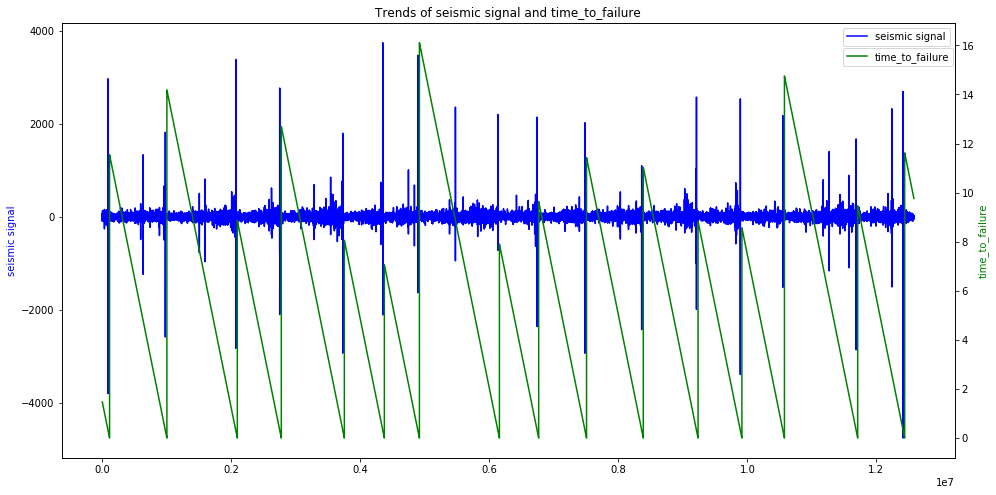

In [49]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of seismic signal and time_to_failure")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('seismic signal', color='b')
plt.legend(['seismic signal'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

C:\Users\Patron\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


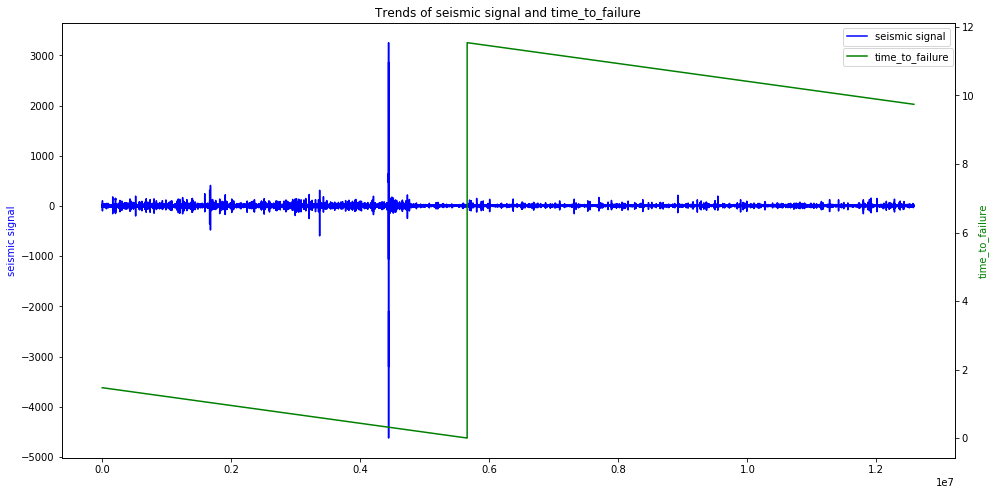

In [50]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of seismic signal and time_to_failure")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('seismic signal', color='b')
plt.legend(['seismic signal'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [6]:
chunk_size = 150000

chunks = int(np.floor(train_df.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [7]:
from tqdm import tqdm
for chunk_no in tqdm(range(chunks)):
    data_chunk = train_df.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████| 4194/4194 [00:37<00:00, 113.24it/s]


In [8]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()


(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape


(3355, 11)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional, GRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization


#keras.layers.GRU(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, reset_after=False)

model = Sequential()
model.add(GRU(512, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1), return_sequences = True,recurrent_dropout = 0.2))
#model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(GRU(256, recurrent_dropout = 0.3))
#model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.20))
# model.add(Flatten())
model.add(Dense(1))


In [15]:
# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

print(X_train_array.shape)
print(y_train_array.shape)

(3355, 11, 1)
(3355, 1, 1)


In [16]:
# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mae", "mse"])
#model.summary()

build = model.fit(X_train_array, y_train, epochs=150, batch_size=30, validation_split = 0.20, verbose=1, shuffle = False)

Train on 2684 samples, validate on 671 samples
Epoch 1/150
2684/2684 [==============================] - 10s 4ms/step - loss: 4.0636 - mae: 4.0636 - mse: 26.9460 - val_loss: 4.4678 - val_mae: 4.4678 - val_mse: 32.2698
Epoch 2/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.9431 - mae: 2.9431 - mse: 13.8506 - val_loss: 3.5080 - val_mae: 3.5080 - val_mse: 20.8043
Epoch 3/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.8747 - mae: 2.8747 - mse: 12.8918 - val_loss: 3.1379 - val_mae: 3.1379 - val_mse: 16.0794
Epoch 4/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.8528 - mae: 2.8528 - mse: 12.8622 - val_loss: 3.0380 - val_mae: 3.0380 - val_mse: 14.6891
Epoch 5/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.8212 - mae: 2.8212 - mse: 12.6305 - val_loss: 2.9842 - val_mae: 2.9842 - val_mse: 13.7546
Epoch 6/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.8090 - mae: 2.8090 - mse: 12

Epoch 49/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.3179 - mae: 2.3179 - mse: 9.1327 - val_loss: 2.4473 - val_mae: 2.4473 - val_mse: 10.8809
Epoch 50/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.2816 - mae: 2.2816 - mse: 8.8137 - val_loss: 2.4475 - val_mae: 2.4475 - val_mse: 10.9014
Epoch 51/150
2684/2684 [==============================] - 10s 4ms/step - loss: 2.3132 - mae: 2.3132 - mse: 9.0885 - val_loss: 2.5249 - val_mae: 2.5249 - val_mse: 11.5280
Epoch 52/150
2684/2684 [==============================] - 10s 4ms/step - loss: 2.3026 - mae: 2.3026 - mse: 8.9704 - val_loss: 2.4727 - val_mae: 2.4727 - val_mse: 11.1315
Epoch 53/150
2684/2684 [==============================] - 10s 4ms/step - loss: 2.2916 - mae: 2.2916 - mse: 8.8969 - val_loss: 2.4851 - val_mae: 2.4851 - val_mse: 11.2366
Epoch 54/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.2791 - mae: 2.2791 - mse: 8.9023 - val_loss: 2.5409 - val_mae: 2.5409 - 

2684/2684 [==============================] - 9s 3ms/step - loss: 2.1907 - mae: 2.1907 - mse: 8.2560 - val_loss: 2.3677 - val_mae: 2.3677 - val_mse: 10.4787
Epoch 98/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.2129 - mae: 2.2129 - mse: 8.4496 - val_loss: 2.3751 - val_mae: 2.3751 - val_mse: 10.5411
Epoch 99/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1694 - mae: 2.1694 - mse: 8.2094 - val_loss: 2.3598 - val_mae: 2.3598 - val_mse: 10.4156
Epoch 100/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1776 - mae: 2.1776 - mse: 8.1671 - val_loss: 2.3704 - val_mae: 2.3704 - val_mse: 10.5030
Epoch 101/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1858 - mae: 2.1858 - mse: 8.2363 - val_loss: 2.3332 - val_mae: 2.3332 - val_mse: 10.2037
Epoch 102/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1869 - mae: 2.1869 - mse: 8.2699 - val_loss: 2.3388 - val_mae: 2.3388 - val_mse: 10.2

2684/2684 [==============================] - 9s 3ms/step - loss: 2.1714 - mae: 2.1714 - mse: 8.2261 - val_loss: 2.3348 - val_mae: 2.3348 - val_mse: 10.1915
Epoch 146/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1681 - mae: 2.1681 - mse: 8.2013 - val_loss: 2.2668 - val_mae: 2.2668 - val_mse: 9.5831
Epoch 147/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1552 - mae: 2.1552 - mse: 8.0555 - val_loss: 2.2980 - val_mae: 2.2980 - val_mse: 9.8727
Epoch 148/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1622 - mae: 2.1622 - mse: 8.1672 - val_loss: 2.3276 - val_mae: 2.3276 - val_mse: 10.1335
Epoch 149/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.1758 - mae: 2.1758 - mse: 8.2370 - val_loss: 2.2955 - val_mae: 2.2955 - val_mse: 9.8471
Epoch 150/150
2684/2684 [==============================] - 10s 4ms/step - loss: 2.1775 - mae: 2.1775 - mse: 8.3204 - val_loss: 2.3167 - val_mae: 2.3167 - val_mse: 10.0

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


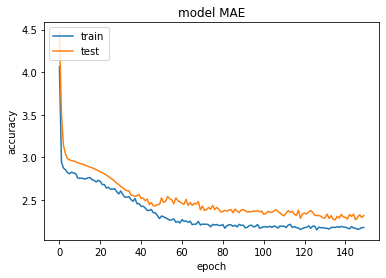

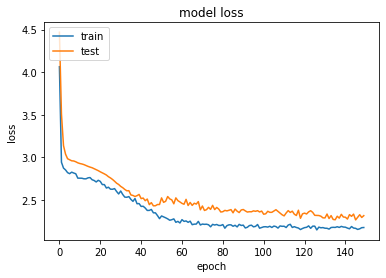

In [18]:
import matplotlib.pyplot as plt
# list all data in history
print(build.history.keys())
# summarize history for accuracy
plt.plot(build.history['mae'])
plt.plot(build.history['val_mae'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
model.save("model-GRU-single.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
submission = pd.read_csv("../data/sample_submission.csv", index_col='seg_id', dtype={"time_to_failure": np.float32})
X_sub = pd.DataFrame(columns=X_data.columns, dtype=np.float32)

for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('../data/test/' + str(seg_id) + '.csv')
    X_seg = create_features(seg, X_sub, i)

100%|██████████| 2624/2624 [00:50<00:00, 51.95it/s]


In [23]:
X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
pred_final = model.predict(X_seg_array)
submission['time_to_failure'] = pred_final

submission.to_csv('submission-GRU-single.csv')

            time_to_failure
seg_id                     
seg_004314         0.660166
seg_20cc25         0.978260
seg_26a2a0         0.377912
seg_272a47         0.878321
seg_2f86cd         0.510108
seg_376908         0.872885
seg_39ad50         0.617726
seg_3e87b4         0.713263
seg_5311d1         0.931226
seg_724df9         0.367125
seg_7848f8         0.443548
seg_7a9f2b         0.411190
seg_7fa6ec         0.386437
seg_8be76c         0.824842
seg_90b174         0.884478
seg_919a6a         0.975649
seg_957ece         0.728189
seg_aa98cc         0.397465
seg_b35174         0.379416
seg_b686e5         0.663701
seg_bfdd14         0.701796
seg_c243a6         0.740814
seg_c5dee4         0.742274
seg_c80857         0.382651
seg_c94941         0.784773
seg_c9831a         0.909643
seg_e3d751         0.320170
seg_f43ab6         0.857341
seg_fdd50e         0.884366
<class 'pandas.core.frame.DataFrame'>
Index(['time_to_failure'], dtype='object')
seg_26a2a0


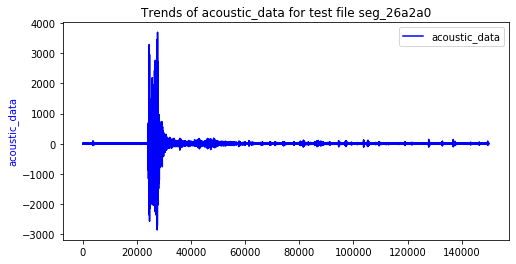

In [27]:
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
print(type(possible_eq))
print(possible_eq.columns)
segments = ["seg_26a2a0"]
for seg_id in segments:
    print(seg_id)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

In [35]:
import dill
#dill.dump_session('notebook_env.db')


ModuleNotFoundError: No module named 'dill'